# Multigrid examples

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import print_function

import numpy as np

import mesh.boundary as bnd
import mesh.patch as patch
import multigrid.MG as MG

## Constant-coefficent Poisson equation

We want to solve 

$$\phi_{xx} + \phi_{yy} = -2[(1-6x^2)y^2(1-y^2) + (1-6y^2)x^2(1-x^2)]$$

on 

$$[0,1]\times [0,1]$$ 

with homogeneous Dirichlet boundary conditions (this example comes from "A Multigrid Tutorial").

This has the analytic solution
$$u(x,y) = (x^2 - x^4)(y^4 - y^2)$$

We start by setting up a multigrid object--this needs to know the number of zones our problem is defined on

In [3]:
nx = ny = 256
mg = MG.CellCenterMG2d(nx, ny, 
                       xl_BC_type="dirichlet", xr_BC_type="dirichlet",
                       yl_BC_type="dirichlet", yr_BC_type="dirichlet", verbose=1)

cc data: nx = 2, ny = 2, ng = 1
         nvars = 3
         variables:
               v: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: dirichlet    +x: dirichlet    -y: dirichlet    +y: dirichlet   
               f: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: dirichlet    +x: dirichlet    -y: dirichlet    +y: dirichlet   
               r: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: dirichlet    +x: dirichlet    -y: dirichlet    +y: dirichlet   

cc data: nx = 4, ny = 4, ng = 1
         nvars = 3
         variables:
               v: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: dirichlet    +x: dirichlet    -y: dirichlet    +y: dirichlet   
               f: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: dirichlet    +x: dirichlet    -y: dirichlet    +y: dirichlet   
               r: min:    0.0000000000    max:    0.0000000000
                  BCs: -

Next, we initialize the RHS.  To make life easier, the `CellCenterMG2d` object has the coordinates of the solution grid (including ghost cells) as `mg.x2d` and `mg.y2d` (these are two-dimensional arrays).

In [4]:
def rhs(x, y):
    return -2.0*((1.0-6.0*x**2)*y**2*(1.0-y**2) + (1.0-6.0*y**2)*x**2*(1.0-x**2))

mg.init_RHS(rhs(mg.x2d, mg.y2d))

Source norm =  1.097515813669473


The last setup step is to initialize the solution--this is the starting point for the solve.  Usually we just want to start with all zeros, so we use the `init_zeros()` method

In [5]:
mg.init_zeros()

we can now solve -- there are actually two different techniques we can do here.  We can just do pure smoothing on the solution grid using `mg.smooth(mg.nlevels-1, N)`, where `N` is the number of smoothing iterations.  To get the solution `N` will need to be large and this will take a long time.

Multigrid accelerates the smoothing.  We can do a V-cycle multigrid solution using `mg.solve()`

In [6]:
mg.solve()

source norm =  1.097515813669473
<<< beginning V-cycle (cycle 1) >>>

  level: 7, grid: 256 x 256
  before G-S, residual L2: 1.097515813669473
  after G-S, residual L2: 1.502308451578657

  level: 6, grid: 128 x 128
  before G-S, residual L2: 1.0616243965458263
  after G-S, residual L2: 1.4321452257629033

  level: 5, grid: 64 x 64
  before G-S, residual L2: 1.011366277976364
  after G-S, residual L2: 1.281872470375375

  level: 4, grid: 32 x 32
  before G-S, residual L2: 0.903531158162907
  after G-S, residual L2: 0.9607576999783505

  level: 3, grid: 16 x 16
  before G-S, residual L2: 0.6736112182020367
  after G-S, residual L2: 0.4439774050299674

  level: 2, grid: 8 x 8
  before G-S, residual L2: 0.30721142286171554
  after G-S, residual L2: 0.0727215591269748

  level: 1, grid: 4 x 4
  before G-S, residual L2: 0.04841813458618458
  after G-S, residual L2: 3.9610700301811246e-05

  bottom solve:
  level: 0, grid: 2 x 2

  level: 1, grid: 4 x 4
  before G-S, residual L2: 3.925006722

We can access the solution on the finest grid using `get_solution()`

In [7]:
phi = mg.get_solution()

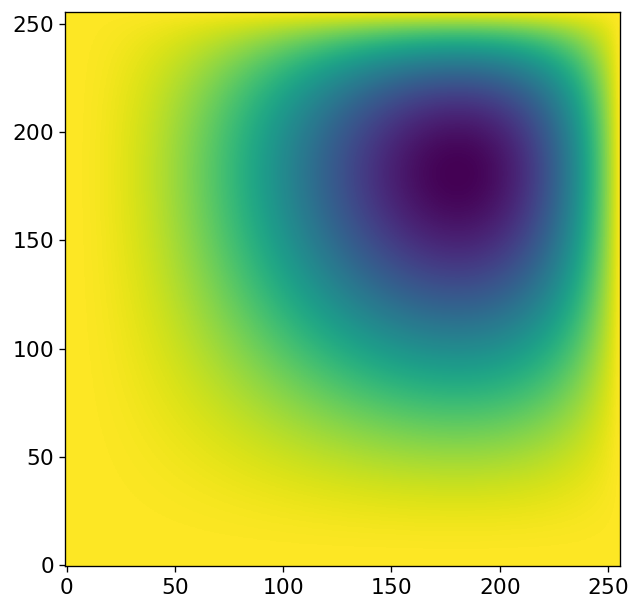

In [8]:
plt.imshow(np.transpose(phi.v()), origin="lower")

we can also get the gradient of the solution

In [9]:
gx, gy = mg.get_solution_gradient()

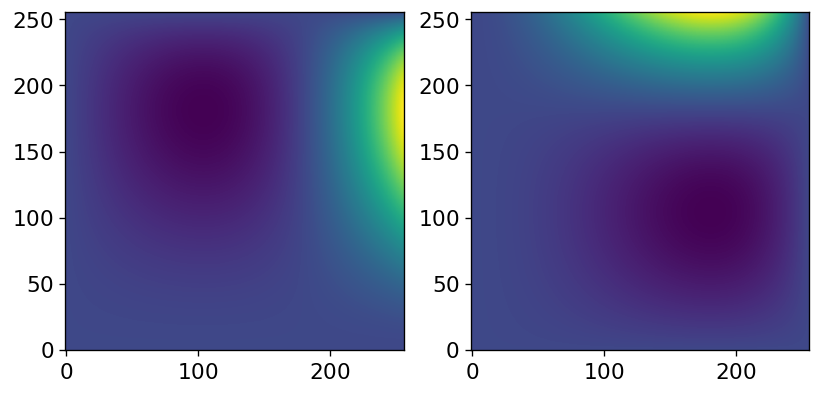

In [10]:
plt.subplot(121)
plt.imshow(np.transpose(gx.v()), origin="lower")
plt.subplot(122)
plt.imshow(np.transpose(gy.v()), origin="lower")

## General linear elliptic equation

The `GeneralMG2d` class implements support for a general elliptic equation of the form:

$$\alpha \phi + \nabla \cdot (\beta \nabla \phi) + \gamma \cdot \nabla \phi = f$$

with inhomogeneous boundary condtions.

It subclasses the `CellCenterMG2d` class, and the basic interface is the same

We will solve the above with

\begin{align}
\alpha &= 10 \\
\beta &= xy + 1 \\
\gamma &= \hat{x} + \hat{y}
\end{align}

and


\begin{equation}
f = -\frac{\pi}{2}(x + 1)\sin\left(\frac{\pi y}{2}\right) \cos\left(\frac{\pi x}{2}\right ) -\frac{\pi}{2}(y + 1)\sin\left(\frac{\pi x}{2}\right) \cos\left(\frac{\pi y}{2}\right ) +\left(\frac{-\pi^2 (xy+1)}{2} + 10\right) \cos\left(\frac{\pi x}{2}\right) \cos\left(\frac{\pi y}{2}\right)
\end{equation}


on $[0, 1] \times [0,1]$ with boundary conditions:

\begin{align}
\phi(x=0) &= \cos(\pi y/2) \\
\phi(x=1) &= 0 \\
\phi(y=0) &= \cos(\pi x/2) \\
\phi(y=1) &= 0
\end{align}


This has the exact solution:

$$\phi = \cos(\pi x/2) \cos(\pi y/2)$$

In [11]:
import multigrid.general_MG as gMG

For reference, we'll define a function providing the analytic solution

In [12]:
def true(x,y):                                                                                         
    return np.cos(np.pi*x/2.0)*np.cos(np.pi*y/2.0)                                                     

Now the coefficents--note that since $\gamma$ is a vector, we have a different function for each component

In [13]:
def alpha(x,y):                                                                                        
    return 10.0*np.ones_like(x)                                                                        
                                                                                                       
def beta(x,y):                                                                                         
    return x*y + 1.0                                                                                   
                                                                                                       
def gamma_x(x,y):                                                                                      
    return np.ones_like(x)                                                                             
                                                                                                       
def gamma_y(x,y):                                                                                      
    return np.ones_like(x)                                                                             

and the righthand side function

In [14]:
def f(x,y):
    return -0.5*np.pi*(x + 1.0)*np.sin(np.pi*y/2.0)*np.cos(np.pi*x/2.0) - \
            0.5*np.pi*(y + 1.0)*np.sin(np.pi*x/2.0)*np.cos(np.pi*y/2.0) + \
            (-np.pi**2*(x*y+1.0)/2.0 + 10.0)*np.cos(np.pi*x/2.0)*np.cos(np.pi*y/2.0)

Our inhomogeneous boundary conditions require a function that can be evaluated on the boundary to give the value

In [15]:
def xl_func(y):
    return np.cos(np.pi*y/2.0)

def yl_func(x):
    return np.cos(np.pi*x/2.0)

Now we can setup our grid object and the coefficients, which are stored as a `CellCenter2d` object.  Note, the coefficients do not need to have the same boundary conditions as $\phi$ (and for real problems, they may not).  The one that matters the most is $\beta$, since that will need to be averaged to the edges of the domain, so the boundary conditions on the coefficients are important.

Here we use Neumann boundary conditions

In [16]:
import mesh.patch as patch

nx = ny = 128

g = patch.Grid2d(nx, ny, ng=1)
d = patch.CellCenterData2d(g)

bc_c = bnd.BC(xlb="neumann", xrb="neumann",
              ylb="neumann", yrb="neumann")

d.register_var("alpha", bc_c)
d.register_var("beta", bc_c)
d.register_var("gamma_x", bc_c)
d.register_var("gamma_y", bc_c)
d.create()

a = d.get_var("alpha")
a[:,:] = alpha(g.x2d, g.y2d)

b = d.get_var("beta")
b[:,:] = beta(g.x2d, g.y2d)

gx = d.get_var("gamma_x")
gx[:,:] = gamma_x(g.x2d, g.y2d)

gy = d.get_var("gamma_y")
gy[:,:] = gamma_y(g.x2d, g.y2d)

Now we can setup the multigrid object

In [17]:
a = gMG.GeneralMG2d(nx, ny,
                    xl_BC_type="dirichlet", yl_BC_type="dirichlet",
                    xr_BC_type="dirichlet", yr_BC_type="dirichlet",
                    xl_BC=xl_func,
                    yl_BC=yl_func,
                    coeffs=d,
                    verbose=1, vis=0, true_function=true)

cc data: nx = 2, ny = 2, ng = 1
         nvars = 7
         variables:
               v: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: dirichlet    +x: dirichlet    -y: dirichlet    +y: dirichlet   
               f: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: dirichlet    +x: dirichlet    -y: dirichlet    +y: dirichlet   
               r: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: dirichlet    +x: dirichlet    -y: dirichlet    +y: dirichlet   
           alpha: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: neumann      +x: neumann      -y: neumann      +y: neumann     
            beta: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: neumann      +x: neumann      -y: neumann      +y: neumann     
         gamma_x: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: neumann      +x: neumann      -y: neumann      +y: neumann     
     

just as before, we specify the righthand side and initialize the solution

In [18]:
a.init_zeros()
a.init_RHS(f(a.x2d, a.y2d))

Source norm =  1.775181492337501


and we can solve it

In [19]:
a.solve(rtol=1.e-10)

source norm =  1.775181492337501
<<< beginning V-cycle (cycle 1) >>>

  level: 6, grid: 128 x 128
  before G-S, residual L2: 1.775181492337501
  after G-S, residual L2: 188.9332667507471

  level: 5, grid: 64 x 64
  before G-S, residual L2: 129.93801550392877
  after G-S, residual L2: 56.28708770794367

  level: 4, grid: 32 x 32
  before G-S, residual L2: 38.88692621665777
  after G-S, residual L2: 18.722754099081875

  level: 3, grid: 16 x 16
  before G-S, residual L2: 12.926068140514912
  after G-S, residual L2: 6.7418584016115615

  level: 2, grid: 8 x 8
  before G-S, residual L2: 4.646478379380239
  after G-S, residual L2: 2.0651261541465873

  level: 1, grid: 4 x 4
  before G-S, residual L2: 1.3745334259197388
  after G-S, residual L2: 0.022445197218592287

  bottom solve:
  level: 0, grid: 2 x 2

  level: 1, grid: 4 x 4
  before G-S, residual L2: 0.03125252087247734
  after G-S, residual L2: 8.232822131646219e-05

  level: 2, grid: 8 x 8
  before G-S, residual L2: 2.8059768631102

We can compare to the true solution

In [20]:
v = a.get_solution()
b = true(a.x2d, a.y2d)
e = v - b

The norm of the error is

In [21]:
print(f"{e.norm():20.10g}")

     1.671934405e-05
